## IBM Quantum Challenge 2021

<b>Challenge 5</b> - Using VQE in Qiskit Nature, find the smallest ansatz with high chemical accuracy to simulate the ground state energy of lithium hydride molecule
<br><b>Final Results</b> -
* Score - 3 (Number of CNOT gates in ansatz)
* Chemical Accuracy - 2.35 mHa
* Number of Ansatz Paramters - 16

### Imports

In [1]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.freeze_core_transformer import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit import Aer
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.drivers import PySCFDriver
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os.path

### Defining various functions
<b>Note : </b> No changes are required in the cell below unless you wish to design a custom ansartz

In [2]:
# Function to setup ElectronicStructureProblem, Qubit Operator and HartreeFock Initial State
def prepare_converter_init_state(driver,mapper_type,two_qubit_reduction,freeze_core,remove_orbitals,use_z2,z2symmetry_reduction,log = True):
    if freeze_core:
        if (len(remove_orbitals) > 0):
            problem = ElectronicStructureProblem(driver, q_molecule_transformers = [FreezeCoreTransformer(freeze_core = freeze_core, remove_orbitals = remove_orbitals)])
        else:
            problem = ElectronicStructureProblem(driver, q_molecule_transformers = [FreezeCoreTransformer(freeze_core = freeze_core)])
    else:
        problem = ElectronicStructureProblem(driver)
    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    # Hamiltonian
    main_op = second_q_ops[0]

    # Setup the mapper and qubit converter

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
        
    if use_z2:
        converter = QubitConverter(mapper=mapper, two_qubit_reduction=two_qubit_reduction,z2symmetry_reduction=z2symmetry_reduction)
    else:
        converter = QubitConverter(mapper=mapper, two_qubit_reduction=two_qubit_reduction)

    # The fermionic operators are mapped to qubit operators
    num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
    qubit_op = converter.convert(main_op, num_particles=num_particles)

    num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    if log:
        print("Num spin orbitals : ",num_spin_orbitals)
        print("Number of qubits : ",qubit_op.num_qubits)
        print("init State : \n",init_state)
    
    return problem,qubit_op,init_state,converter





# Function to create desired ansatz
def create_ansatz(ansatz_type,problem,qubit_op,init_state,converter,two_local_params,log = True):
    # Parameters for q-UCC ansatze
    num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
    num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = two_local_params[0]
        # Entangling gates
        entanglement_blocks = two_local_params[1]
        # How the qubits are entangled 
        entanglement = two_local_params[2]
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = two_local_params[3]
        # Skip the final rotation_blocks layer
        skip_final_rotation_layer = two_local_params[4]
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "Custom":
        # Example of how to write your own circuit
        # Define the variational parameter
        theta = Parameter('a')
        n = qubit_op.num_qubits
        # Make an empty quantum circuit
        qc = QuantumCircuit(qubit_op.num_qubits)
        qubit_label = 0
        # Place a Hadamard gate
        qc.h(qubit_label)
        # Place a CNOT ladder
        for i in range(n-1):
            qc.cx(i, i+1)
        # Visual separator
        qc.barrier()
        # rz rotations on all qubits
        qc.rz(theta, range(n))
        ansatz = qc
        ansatz.compose(init_state, front=True, inplace=True)
    
    if log:
        print(ansatz)    
    return ansatz




# Function to setup backend
def prepare_backend():
    backend = Aer.get_backend('statevector_simulator')
    return backend




# Function to setup desired optimizer
def create_optimizer(optimizer_type,param):
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=param)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun=param)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=param)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=param)
    return optimizer




# Function to find ground state energy using exact diagonalizer
def exact_diagonalizer(problem, converter, qmolecule, use_z2, log = True):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
#     print("\n\nResult from Exact diagonalizer : ",result)
    exact_energy = np.real(result.eigenenergies[0])
    print("Exact electronic energy : ", exact_energy )
    if (not use_z2 and log):
        # If z2 symmetry is used, then printing result throws error but rest part works OK.
        print("Result of diagonalizer : ",result)
    return exact_energy





# Callback function to rint and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    if(eval_count%100 == 0):
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
#     clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

    
    
    

# Function to execute the VQE algorithm
def execute_VQE(ansatz,optimizer,backend,qubit_op):
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)

    print("\n\n\nResult from VQE : ",result)
    return result





# Function to log results and paramters for easy iterations
def log_results(freeze_core,remove_orbitals,two_qubit_reduction,use_z2,z2symmetry_reduction,ansatz,ansatz_type,two_local_params,optimizer,param,result,converter,exact_energy,accuracy_threshold,qubit_op,filename):
    # Unroller transpile your circuit into CNOTs and U gates
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    score = cnots

    energy = result.optimal_value
    
    # Setting up logging parameters
    if use_z2: # Beacuse if z2 symmetries are used then exact diagnalizer throws errors
        z2symmetry_reduction = z2symmetry_reduction
    else :
        z2symmetry_reduction = False
    
    if ansatz_type == "TwoLocal":
        ansatz_parameters = two_local_params
    else:
        ansatz_parameters = None
    
    result_dict = {
            'freeze_core': freeze_core,
            'remove_orbitals': remove_orbitals,
            'mapping': converter.mapper.__class__.__name__,
            'two_qubit_reduction': two_qubit_reduction,
            'z2symmetry_reduction': z2symmetry_reduction,
            '# of qubits': int(qubit_op.num_qubits),
            'ansatz': ansatz.__class__.__name__,
            'ansatz_parameters': ansatz_parameters,
            'optimizer': optimizer.__class__.__name__,
            'optimizer_param': param,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            'exact_energy_diagonalizer': exact_energy,
            'energy_VQE (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            '# of CNOTs': cnots,
            'score': score}
    # Plot the results

    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Energy')
    ax.grid()
    fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
    plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
    ax.plot(counts, values)
    ax.axhline(exact_energy, linestyle='--')
    fig_title = f"\
    {result_dict['optimizer']}-\
    {result_dict['mapping']}-\
    {result_dict['ansatz']}-\
    Energy({result_dict['energy_VQE (Ha)']:.3f})-\
    Score({result_dict['score']:.0f})\
    .png"
    fig.savefig(fig_title, dpi=300)

    # Display and save the data
    if os.path.isfile(filename):
        result_df = pd.read_csv(filename)
        result_df = result_df.append([result_dict])
    else:
        result_df = pd.DataFrame.from_dict([result_dict])
    result_df.to_csv(filename)
    display(result_df[['freeze_core','remove_orbitals', 'mapping', 'two_qubit_reduction', 'z2symmetry_reduction', '# of qubits',
                       'ansatz', 'ansatz_parameters', 'optimizer', 'optimizer_param', '# of parameters',
                       'final parameters', '# of evaluations', 'optimizer time', 'exact_energy_diagonalizer', 'energy_VQE (Ha)', 'error (mHa)', 
                       'pass', '# of CNOTs', 'score']])
            

### Choose the molecule and setup PySCF Driver (No changes required)

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

### Setup some empty lists for storing VQE results across iterations (No changes required)

In [4]:
counts = []
values = []
params = []
deviation = []


### Choose different values for various parameters
<b>Note: </b> This is the only code cell in the file that someone needs to change in order to complete the challenge and find optimized ansatz

In [5]:
# Whether to freeze core or not
freeze_core = True

# Type of Mapper to be used. Choose from ParityMapper, JordanWignerMapper or BravyiKitaevMapper 
mapper_type = 'ParityMapper'

# Whether to use two_qubit_reduction or not
two_qubit_reduction = True

# Orbitals to be dropped
remove_orbitals = [3,4]

# Boolean falg to indicate use of z2symmetry_reduction
use_z2 = True

# Value for z2_symmetry_reduction
z2symmetry_reduction = [1]

# Type of Ansatz to be used. Choose from TwoLocal, UCCSD, PUCCD, SUCCD and Custom.
# Note: Need to modify the create_ansatz function if choosing Custom ansatz
ansatz_type = "TwoLocal"

# Parameters for TwoLocal ansatz
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cx'
entanglement = 'linear'
repetitions = 1
skip_final_rotation_layer = False
two_local_params = (rotation_blocks,entanglement_blocks,entanglement,repetitions,skip_final_rotation_layer)

# Type of optimizer to be used. Choose from COBYLA, LBFGS_B, SPSA, SLSQP
optimizer_type = 'SLSQP'

# Maximum number of iterations for optimizer selected
param = 1000

# Accuracy threshold for difference between energies from exact diagonalizer and VQE.
accuracy_threshold = 4.0

# filename to store log results
filename = "result_LiH_final_submission.csv"

### Just call the functions with the selected parameter values and let Qiskit and Python do their magic!




###########################################################################
Preparing converter and initial state...
###########################################################################
Num spin orbitals :  6
Number of qubits :  4
init State : 
      ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          



###########################################################################
Creating ansatz...
###########################################################################
        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤    

'Evaluation: 100, Energy: -0.2666213228031553, Std: 0.0'

'Evaluation: 200, Energy: -0.9101073615645243, Std: 0.0'

'Evaluation: 300, Energy: -1.0245703288754782, Std: 0.0'

'Evaluation: 400, Energy: -1.0706642816527983, Std: 0.0'

'Evaluation: 500, Energy: -1.072872327304966, Std: 0.0'

'Evaluation: 600, Energy: -1.0805868538987673, Std: 0.0'

'Evaluation: 700, Energy: -1.0863110038556292, Std: 0.0'




Result from VQE :  {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39153017e-03+1.62953787e-04j, -4.80304267e-03-1.46976488e-04j,
        2.62444808e-02+8.47731333e-04j, -9.91330331e-01+1.36786903e-02j,
       -5.37470550e-02-3.77338503e-03j, -3.69779846e-04-8.90563958e-05j,
        8.79293615e-04-4.46254552e-06j, -2.32787792e-02+1.49218212e-03j,
       -2.67407972e-03-7.05477595e-05j, -1.12263291e-05-8.31792072e-06j,
        3.68265407e-06+2.34934485e-05j,  3.09333170e-04-9.11069070e-04j,
        1.13571617e-01-2.69511719e-03j,  5.56491562e-04+1.40708292e-04j,
       -5.49268433e-04+3.83120625e-05j, -3.17555135e-05-1.91950112e-05j]),
    'eigenvalue': -1.086347202590231,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): -3.1415137371101394,
                              ParameterVectorElement(θ[1]): -0.005425220149762349,
                              ParameterVectorElement(θ[4]): -0.045184012352035306,
                   

,freeze_core,remove_orbitals,mapping,two_qubit_reduction,z2symmetry_reduction,# of qubits,ansatz,ansatz_parameters,optimizer,optimizer_param,# of parameters,final parameters,# of evaluations,optimizer time,exact_energy_diagonalizer,energy_VQE (Ha),error (mHa),pass,# of CNOTs,score
0,True,[3],ParityMapper,True,[1],5,UCCSD,NaN,COBYLA,1000,9,[ 0.03487811 0.00410916 0.03445793 0.004135...,194,2.827768,-1.089252,-1.089252,0.000017,True,258,258
1,True,[3],ParityMapper,True,[1],5,TwoLocal,"(['ry', 'rz'], 'cx', 'linear', 4, True)",COBYLA,20000,40,[ 2.71158660e-03 -6.71984210e-04 3.55206283e-...,20000,122.844705,-1.089252,-1.086656,2.596235,True,16,16
2,True,"[3, 4]",ParityMapper,True,[1],4,TwoLocal,"(['ry', 'rz'], 'cx', 'linear', 4, True)",COBYLA,50000,32,[-3.08646519e-02 2.73355023e-01 3.12410180e-...,50000,256.175077,-1.088706,-1.086922,1.784227,True,12,12
3,True,"[3, 4]",ParityMapper,True,[1],4,TwoLocal,"(['ry', 'rz'], 'cx', 'circular', 2, True)",SLSQP,1000,16,[-1.14054879e-02 3.13360234e+00 1.00796328e-...,380,1.178133,-1.088706,-1.088290,0.415929,True,8,8
0,True,"[3, 4]",ParityMapper,True,[1],4,TwoLocal,"([ry, rz], cx, linear, 1, False)",SLSQP,1000,16,"[0.2521551551541836, 3.1886768426603678, 0.442...",786,2.410444,-1.088706,-1.086347,2.358813,True,3,3


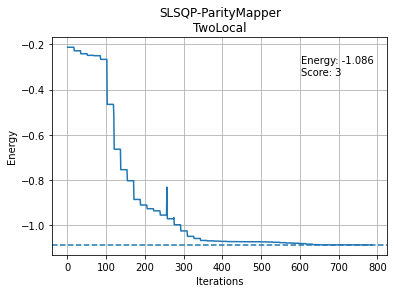

In [6]:
print("\n\n\n###########################################################################")
print("Preparing converter and initial state...")
print("###########################################################################")
problem,qubit_op,init_state,converter = prepare_converter_init_state(driver,mapper_type,two_qubit_reduction,freeze_core,remove_orbitals,use_z2,z2symmetry_reduction)

print("\n\n\n###########################################################################")
print("Creating ansatz...")
print("###########################################################################")
ansatz = create_ansatz(ansatz_type,problem,qubit_op,init_state,converter,two_local_params)
    
print("\n\n\n###########################################################################")
print("Preparing backend...")
print("###########################################################################")
backend = prepare_backend()

print("\n\n\n###########################################################################")
print("Creating optimizer...")
print("###########################################################################")
optimizer = create_optimizer(optimizer_type,param)

print("\n\n\n###########################################################################")
print("Running exact diagonalizer...")
print("###########################################################################")
exact_energy = exact_diagonalizer(problem, converter, qmolecule, use_z2)

print("\n\n\n###########################################################################")
print("Execute VQE...")
print("###########################################################################")
result = execute_VQE(ansatz,optimizer,backend,qubit_op)

print("\n\n\n###########################################################################")
print("Scoring and logging results...")
print("###########################################################################")
log_results(freeze_core,remove_orbitals,two_qubit_reduction,use_z2,z2symmetry_reduction,ansatz,ansatz_type,two_local_params,optimizer,param,result,converter,exact_energy,accuracy_threshold,qubit_op,filename)


### Checking final solution with the grader

In [8]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



### Solution Explanation

Simulating LiH molecule is a harder problem compared to H2 molecule due to a larger system, so the first aim is to reduce the size of problem by reducing the number of qubits by using 
<ul>
    <li>freezing core using FreezeCoreTransformer()</li>
    <li>two_qubit_reduction along with ParityMapper</li>
    <li>removing orbitals</li>
    <li>using z2symmetry_reduction</li>
</ul>
<br>
So this reduces our number of qubits from 12 to 4 without much change in ground state energy
<br>
Now the problem comes down to try and minimizing the number of CNOT gates in the ansatz by changing optimizer, ansatz type and ansatz paramters
<br><br>
My scores for this exercise went like   <b>258 -> 16 -> 12 -> 8 -> 3</b>
<br><br>
To get to a lower number of qubits, the orbitals to be dropped should be chosen carefully. One way of selecting orbitals to drop is to drop different orbitals and then monitoring, the ground state energy from the exact diagonalizer so that it doesn't suffer too big a change.
<br>
So this results into the fact that orbitals 3 and 4 can be dropped in this problem.
<br>
So dropping orbital 3 and changing ansatz to UCCSD alongwith increasing optimizer paramters to 1000, achieves my first score of 258
<br><br>
UCCSD ansatz has a lot of gates and hence can't be used to get to a very good score, so TwoLocal ansatz was used to get to further lower scores alongwith parameter optimization.
<br>
In order to get to lower scores, the optimizer SLSQP is found to be doing a better job then COBYLA alongwith an increased number of iterations.
<br><br>
The following paramters were optimized to get a score of 3:
<ul>
    <li><b>'repetitions'</b> which controls how many times the sequence of gates is repeated in the ansatz and hence it is slowly reduced to lowest possible value of 1.</li>
    <li><b>'entanglement'</b> which controls how the qubits are connected with entangling gates and the minimal way to entangle qubits is using linear mode which connects every qubit with its next qubit only.</li>
    <li><b>'skip_final_rotation_layer'</b> was also found helpful to optimize VQE results better when its set to False.</li>
</ul>
<br><br>
So the whole process can be summarized as:
* Reducing the number of qubits
* Figuring out the best(shallower) ansatz
* Figuring out the best optimizer
* Optimizing various parameters of the ansatz
<br><br>
<b>Note :</b> The logs for all my scores alongwith all parameter details are being stored in file <b>ex5-RaviBansal-results.csv</b>